# Consistency of Obs Trends

This notebook intends to investigate the consistency of the observed trends, by using model trends: is the trend consiustent when fixing thr number of stations?

#### import modules

In [1]:
import pyaerocom as pya
import pandas as pd
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import scipy.stats as stats
import simplejson as json
import numpy as np
import datetime
import copy
import pwlf
import seaborn as sns

Initating pyaerocom configuration
Checking database access...
Checking access to: /lustre/storeA
Access to lustre database: True
Init data paths for lustre
Expired time: 0.018 s


#### computation parameters

In [2]:
min_dobs = 300 #minimum number of daily observations available in order to keep the station
min_nstat = 2 #minimum number of stations required to compute median
sig = 0.95 #significance
min_dim = 5 #minimum number of days required to compute monthly mean
min_mis = 1 #minimum number of months required to compute seasonal mean
min_siy = 4 #minimum number of seasons required to compute annual mean
nseg = 2 #number of segments if no significant linear trend on the time series is found
use_obs_seg = True #if use same segments for model and bias than the ones found in obs (to be run before)

#### dedicated functions

In [3]:
def to_jsdate(dates):
    """Convert datetime vector to jsdate vector"""
    epoch = np.datetime64('1970-01-01')
    return (dates - epoch).astype('timedelta64[ms]').astype(int)

In [4]:
def write_ts(TS, region):
    source = 'AERONET-Sun'
    layer = 'Column'
    fn = path_out + 'regions_ts/OBS-' + source + ':' + var + '_' + layer + '_MOD-None:None_' + region + '.json'
    #export TS as json file
    with open(fn, 'w') as fp:
        json.dump(TS, fp, sort_keys=True, ignore_nan=True)

In [5]:
def write_all_ts(TS):
    source = 'AERONET-Sun'
    layer = 'Column'
    fn = path_out + 'regions_all_ts/OBS-' + source + ':' + var + '_' + layer + '_MOD-None:None' +  '.json'
    #export TS as json file
    with open(fn, 'w') as fp:
        json.dump(TS, fp, sort_keys=True, ignore_nan=True)

In [6]:
def write_map(MAP):
    source = 'AERONET-Sun'
    layer = 'Column'
    fn = path_out + 'regions_map/OBS-' + source + ':' + var + '_' + layer + '_MOD-None:None' + '.json'
    json.dumps(MAP, sort_keys=True, default=str)
    with open(fn, 'w') as fp:
        json.dump(MAP, fp, sort_keys=True, ignore_nan=True)

In [7]:
def compute_trend_error(m, m_err, v0, v0_err):
    delta_sl = m_err / v0
    delta_ref = m * v0_err / v0**2
    return np.sqrt(delta_sl**2 + delta_ref**2) * 100

In [8]:
def compute_trend(x, y, kind, region):
    #function that provide a linear fit, if significant. If not, break out the function within nseg.
    
    #mann kendall test
    tau, pval = stats.kendalltau(x, y)
    
    #theil sen slope
    a, b, low_slope, up_slope = stats.mstats.theilslopes(y, x, alpha=sig)
    #reproject on the whole period asked
    xb = np.arange(int(period.split('-')[0]),int(period.split('-')[1])+1)
    reg = [a * i + b for i in xb]
    rel_slope = a * 100 / reg[0]

    slope_err = np.mean([abs(a - low_slope), abs(a - up_slope)])
    v0_err_data = np.mean(np.abs(y - [a * i + b for i in x]))
    trend_err = compute_trend_error(m=a, m_err=slope_err, v0=reg[0], v0_err=v0_err_data)


    trend = {
        str(xb[0])+'-'+str(xb[-1]): {
            'x': xb,
            'xdate': [np.datetime64(str(y)+'-06-01') for y in xb],
            'y': reg,
            'a': a,
            'b': b,
            'rel_slp': rel_slope,
            'pval': pval,
            'err_rel_slp': trend_err
        }
    }
    
    trend1 = copy.copy(trend)
    pval1 = copy.copy(pval)
    short_period = False
    
    
    #if (kind=='obs' and pval>(1-sig)) or ((kind!='obs' and use_obs_seg)):
    if (kind=='obs') or ((kind!='obs' and use_obs_seg)):
    
        #first, find break points
        #print('needs to break the series')
        # initialize piecewise linear fit with your x and y data
        my_pwlf = pwlf.PiecewiseLinFit(x, y)
        if kind!='obs' and use_obs_seg:
            #print('use obs segments')
            # fit the data for nseg line segments
            segs = list(OBS_MAP[region]['trends']['trends'].keys())
            if len(segs)<=1:
                #print('obs do not have segments')
                #print(trend)
                return trend
            else:
                trend = {}
                breaks = [int(segs[0].split('-')[0]), int(segs[0].split('-')[1]), int(segs[1].split('-')[1])]
                #print('obs breaks: ',breaks)
        else:
            trend = {}
            # fit the data for nseg line segments
            breaks = [int(round(x)) for x in my_pwlf.fit(nseg)]
            
        #loop over segments
        for i in np.arange(nseg):
            mask = [(x>=breaks[i]) & (x<=breaks[i+1])]
            x2 = x[mask]
            y2 = y[mask]
            
            if (len(x2)>3):
                #mann kendall test
                tau, pval = stats.kendalltau(x2, y2)
                #theil sen slope
                a, b, low_slope, up_slope = stats.mstats.theilslopes(y2, x2, alpha=sig)
                #reproject on the whole period asked for first and last segment
                xb = x2
                if i==0:
                    xb = np.arange(int(period.split('-')[0]),x2[-1]+1)
                if i==nseg:
                    xb = np.arange(x2[0],int(period.split('-')[1])+1)
                    
                reg = [a * i + b for i in xb]
                rel_slope = a * 100 / reg[0]
                
                slope_err = np.mean([abs(a - low_slope), abs(a - up_slope)])
                v0_err_data = np.mean(np.abs(y2 - [a * i + b for i in x2]))
                trend_err = compute_trend_error(m=a, m_err=slope_err, v0=reg[0], v0_err=v0_err_data)

                trend[str(xb[0])+'-'+str(xb[-1])] = {
                    'x': xb,
                    'xdate': [np.datetime64(str(y)+'-06-01') for y in xb],
                    'y': reg,
                    'a': a,
                    'b': b,
                    'rel_slp': rel_slope,
                    'pval': pval,
                    'err_rel_slp': trend_err
                }
            else:
                xb = x2
                trend[str(xb[0])+'-'+str(xb[-1])] = {
                    'x': [],
                    'xdate': [],
                    'y': [],
                    'a': None,
                    'b': None,
                    'rel_slp': None,
                    'pval': None,
                    'err_rel_slp': None
                }
                short_period = True
    
    #compare p-values
    if kind=='obs':
        seg_pval = []
        for seg in trend.keys():
            if (trend[seg]['pval']!=None):
                seg_pval.append(trend[seg]['pval'])
        if min(seg_pval)>=pval1 or short_period==True:
            trend = trend1
    
    #compute trend along time series
    return trend

In [9]:
def process_trend(data, kind, period, obs=None, colocate_time=True, colocate_space=True, 
                  plot=True, write_json=False, ymin=None, ymax=None, ylabel=None, save_plot=False):
    #by default, colocate model in space and time
    MAP = {}
    DF = {}
    ALL_TS = {}
    regions = pya.region.all()
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    
    #computation region by region
    for region in regions:
        f = pya.Filter(region)
        if kind == 'obs':
            try:
                sub = f(data)
                var = data.vars_to_retrieve[0]
            except:
                print('No station found in the area')
                MAP[region] = {
                    'name': region,
                    'min_lon': pya.Region(region).lon_range[0],
                    'max_lon': pya.Region(region).lon_range[1],
                    'min_lat': pya.Region(region).lat_range[0],
                    'max_lat': pya.Region(region).lat_range[1],
                    'trends': {},
                    'nmax': 0,
                    'stations': [],
                }
                continue
        elif kind == 'mod' or kind == 'bias':
            if obs==None:
                print('kind is model or bias. Needs to pass an obs dataset')
            else:
                try:
                    sub = f(obs)
                    var = data.var_name
                except:
                    print('No station found in the area')
                    MAP[region] = {
                        'name': region,
                        'min_lon': pya.Region(region).lon_range[0],
                        'max_lon': pya.Region(region).lon_range[1],
                        'min_lat': pya.Region(region).lat_range[0],
                        'max_lat': pya.Region(region).lat_range[1],
                        'trends': {},
                        'nmax': 0,
                        'stations': [],
                    }
                    continue

        #for each subset, creates a dataframe containing all stations timeseries
        #first, get station data
        data_all = sub.to_station_data_all()['stats']
        obs_all = copy.copy(data_all)
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        #if model 
        if kind == 'mod':
            if colocate_space: 
                #first, get list of stations name, lat and lon
                stations = { 'name': [], 'lat': [], 'lon': []  }

                for stat in data_all:
                    stations['name'].append(stat['station_name'])
                    stations['lat'].append(stat['station_coords']['latitude'])
                    stations['lon'].append(stat['station_coords']['longitude'])

                data_all = data.to_time_series(longitude=stations['lon'], latitude=stations['lat'],  add_meta=dict(station_name = stations['name']))
            else:
                #creates a filter for the region
                f = pya.Filter(region)
                data_all = f(data)
                med_area = data_all.get_area_weighted_timeseries()
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        
        
        #initialize pandas DataFrame
        df = pd.DataFrame()
        
        stations = []
        if kind=='mod' and colocate_space==False:
            med = med_area[var]
            top = med
            bottom = med
            ts = med.to_frame()
            ts.set_axis([var+'_'+region], axis=1, inplace=True)
            df = pd.concat([df, ts], axis=1)
        else:
            for i, station in enumerate(data_all):
                stat_name = station.station_name
                clear_output(wait=True)
                print('region: ', region)
                print('station: ', stat_name)
                ts_type = station.ts_type
                #set individual time series as dataframe

                #extract pandas series and convert it to datframe
                ts = data_all[i][var].to_frame()
                ts.set_axis([var+'_'+stat_name], axis=1, inplace=True)

                if ts_type == 'daily':
                    if ts.count()[0]>=min_dobs:
                        #concatenates to main dataframe
                        df = pd.concat([df, ts], axis=1)
                else :
                    #concatenates to main dataframe
                    df = pd.concat([df, ts], axis=1)

                stations.append({
                    'name': stat_name,
                    'lat': station.latitude,
                    'lon': station.longitude
                })
            clear_output(wait=False)
                
            #caluclates median and envelope with quartiles
            med = df.median(axis=1)
            top = df.quantile(q=0.75,axis=1)
            bottom = df.quantile(q=0.25,axis=1)
            #requires at least n measurements to provide a valid median
            n = df.count(axis=1, numeric_only=False)
            med = med[n>min_nstat]
            top = top[n>min_nstat]
            bottom = bottom[n>min_nstat]
        
        
        #if model, colocates in time with obs
        if kind=='mod' and colocate_time:
            if region in OBS_DF.keys():
                df =df[OBS_DF[region].shift(-12, freq='H')>=0]
                #caluclates median and envelope with quartiles
                med = df.median(axis=1)
                top = df.quantile(q=0.75,axis=1)
                bottom = df.quantile(q=0.25,axis=1)
                #requires at least n measurements to provide a valid median
                n = df.count(axis=1, numeric_only=False)
                med = med[n>min_nstat]
                top = top[n>min_nstat]
                bottom = bottom[n>min_nstat]
            else:
                continue

        #calculates monthly averages for the plots
        dcount = med.groupby(pd.Grouper(freq='M')).count()
        mmed = med.groupby(pd.Grouper(freq='M')).mean().where(dcount>=min_dim)
        mtop = top.groupby(pd.Grouper(freq='M')).mean().where(dcount>=min_dim)
        mbottom = bottom.groupby(pd.Grouper(freq='M')).mean().where(dcount>=min_dim)
        
        #seasonal averages
        mcount = mmed.groupby(pd.Grouper(freq='Q')).count()
        smed = mmed.groupby(pd.Grouper(freq='Q')).mean().where(mcount>=min_mis)
        
        #yearly averages from seasonal averages
        scount = smed.groupby(pd.Grouper(freq='A')).count()
        ymed = smed.groupby(pd.Grouper(freq='A')).mean().where(scount>=min_siy)
        ymed = ymed.shift(-6, freq ='MS')
        
        y_min = int(period.split('-')[0])
        y_max = int(period.split('-')[1])

        #prepare arrays for trends computation
        x = ymed.index.year.values
        xplot = ymed.index
        y = ymed.values
        #get only valid values
        x = x[~np.isnan(y)]
        xplot = xplot[~np.isnan(y)]
        y = y[~np.isnan(y)]
        #restrict to years within period
        xok, yok = [], []
        for i,_ in enumerate(x):
            if x[i]>=y_min and x[i]<=y_max:
                xok.append(x[i])
                yok.append(y[i])
        xok = np.array(xok)
        yok = np.array(yok)
        
        #write ts json file
        TS = {
            "daily": {
                "jsdate": to_jsdate(med.index).tolist(),
                "data": med.values.tolist(),
                "top": top.values.tolist(),
                "bottom": bottom.values.tolist()
            },
            "monthly": {
                "jsdate": to_jsdate(mmed.index).tolist(),
                "data": mmed.values.tolist(),
                "top": mtop.values.tolist(),
                "bottom": mbottom.values.tolist()
            },
            "yearly": {
                "jsdate": to_jsdate(ymed.index).tolist(),
                "data": ymed.values.tolist(),
            },
            "trends": {}
        }
        
        #trends computation
        if len(xok)==0:
            print('No Data Available in Selected Period')
            MAP[region] = {
                'name': region,
                'min_lon': pya.Region(region).lon_range[0],
                'max_lon': pya.Region(region).lon_range[1],
                'min_lat': pya.Region(region).lat_range[0],
                'max_lat': pya.Region(region).lat_range[1],
                'trends': TS,
                'nmax': len(df.columns),
                'stations': stations,
            }
            continue
        trend = compute_trend(xok, yok, kind, region)

        if plot:
            plotTS(mmed, mbottom, mtop, ymed, trend, region, ymin, ymax, ylabel, save_plot)


        #store every portions of the trend
        for seg in trend.keys():
            if trend[seg]['rel_slp']!=None:
                jsdate = to_jsdate(trend[seg]['xdate']).tolist()
            else:
                jsdate = []
            TS["trends"][seg] = {
                'pval': trend[seg]['pval'],
                'rel_slp': trend[seg]['rel_slp'],
                'abs_slp': trend[seg]['a'],
                'reg0': trend[seg]['b'],
                'n': len(trend[seg]['x']),
                'data': trend[seg]['y'],
                'jsdate': jsdate,
                'err_rel_slp': trend[seg]['err_rel_slp']
            }

        #export TS as json file
        if write_json:
            write_ts(TS, region)

        #append to map dict
        MAP[region] = {
            'name': region,
            'min_lon': pya.Region(region).lon_range[0],
            'max_lon': pya.Region(region).lon_range[1],
            'min_lat': pya.Region(region).lat_range[0],
            'max_lat': pya.Region(region).lat_range[1],
            'trends': TS,
            'nmax': len(df.columns),
            'stations': stations,
        }
        
        ALL_TS[region] = TS
        DF[region] = df

    #export MAP as json file
    if write_json:
        write_map(MAP)
        write_all_ts(ALL_TS)
    
    return TS, MAP, DF

In [10]:
#import seaborn style
sns.set()
sns.set_context("paper")
#sns.set_style("whitegrid")
sns.color_palette("muted")
#since each figure will be a subfigure, increase font_size
fscale = 1.3
sns.set(font_scale=fscale)

def plotTS(mmed, mbottom, mtop, ymed, trend, region, ymin, ymax, ylabel, save_plot):
    #font style
    bold_start = r"$\bf{"
    bold_end = "}$"
    italic_start = r"$\it{"
    italic_end = "}$"
    
    #plot that   
    fig, ax = plt.subplots(figsize=(9, 3), dpi= 300, facecolor='w', edgecolor='k')
    
    #plot monthly averages
    plt.fill_between(mmed.index, mbottom.values, mtop.values, alpha=.2)
    plt.plot(mmed, lw=2, alpha=.5)
    plt.plot(ymed, 'b.', lw=0, ms=12, alpha=1)
    plt.ylim(bottom=0)
    #plot every portions of the trend
    for nseg, seg in enumerate(trend.keys()):
        if len(trend[seg]['xdate'])>0:
            if trend[seg]['pval']<=0.1:
                ls = '-'
                trend_style_start = bold_start
                trend_style_end = bold_end
                unit = '\ \%/yr '
                pm = '\ ±\ '
            if trend[seg]['pval']>0.1 and trend[seg]['pval']<=0.2:
                ls = '--'
                trend_style_start = ''
                trend_style_end = ''
                unit = ' %/yr '
                pm = ' ± '
            if trend[seg]['pval']>0.2:
                ls = ':'
                trend_style_start = italic_start
                trend_style_end = italic_end
                unit = '\ \%/yr '
                pm = '\ ±\ '
            #plot the trend
            plt.plot(trend[seg]['xdate'], trend[seg]['y'], lw=2, linestyle=ls, color=sns.color_palette()[3], alpha=.5)
            
            #write the period
            string = seg+': '
            #xstr = trend[seg]['xdate'][0]+100 #plot when period start. but the text might be out of the plot  when the period starts near the end
            #ystr = ymin+0.9*(ymax-ymin)
            xstr = 0.02
            ystr = 0.9-0.1*nseg
            plt.text(xstr, ystr, string,
                     horizontalalignment='left', verticalalignment='center', 
                     color=(.3,.3,.3), fontsize = 8*fscale,
                     transform=ax.transAxes
                     )
            
            #write the trend
            #xstr = trend[seg]['xdate'][0]+100
            #ystr = ymin+0.8*(ymax-ymin)
            xstr = 0.15
            ystr = 0.9-0.1*nseg
            string = trend_style_start+'{:.1f}'.format(trend[seg]['rel_slp'])+pm+'{:.1f}'.format(trend[seg]['err_rel_slp'])+unit+trend_style_end
            string+='; '+italic_start+'p'+italic_end+'-val: '+'{:.1e}'.format(trend[seg]['pval'])
            plt.text(xstr, ystr, string,
                     horizontalalignment='left', verticalalignment='center', 
                     color=(.2,.2,.2), fontsize = 9*fscale,
                     transform=ax.transAxes,
                     )

            #plot vertival line
            if nseg>0:
                plt.axvline(x=trend[seg]['xdate'][0], ls=':', lw=2, color=(.5,.5,.5), alpha=.6)

    #ax.set_title(region+' '+period)
    if ylabel!=None:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel(var)
    if ymin!=None:
        plt.ylim(bottom=ymin)
    if ymax!=None:
        plt.ylim(top=ymax)
    #limit to period
    #plt.xlim(left=datetime.date(int(period.split('-')[0]),1,1))
    #plt.xlim(right=datetime.date(int(period.split('-')[1])+1,1,1))
        
    #write region at top-right
    ax.text(.97,.85,region,horizontalalignment='right',verticalalignment='center',
            transform=ax.transAxes, fontsize = 14*fscale)
    
    #remmove vertical grid
    sns.despine(left=True)
    
    if save_plot:
        plt.savefig('figs/ts/'+source+'-'+var+'-'+region+'.png', dpi=300, bbox_inches='tight')

#### start with Observations

In [11]:
#pya.browse_database('AERONET*')
path_out = '../../aerosoltrends/data/test/'
#in this notebook, work only with one period
period = '1995-2018'

No Data Available in Selected Period


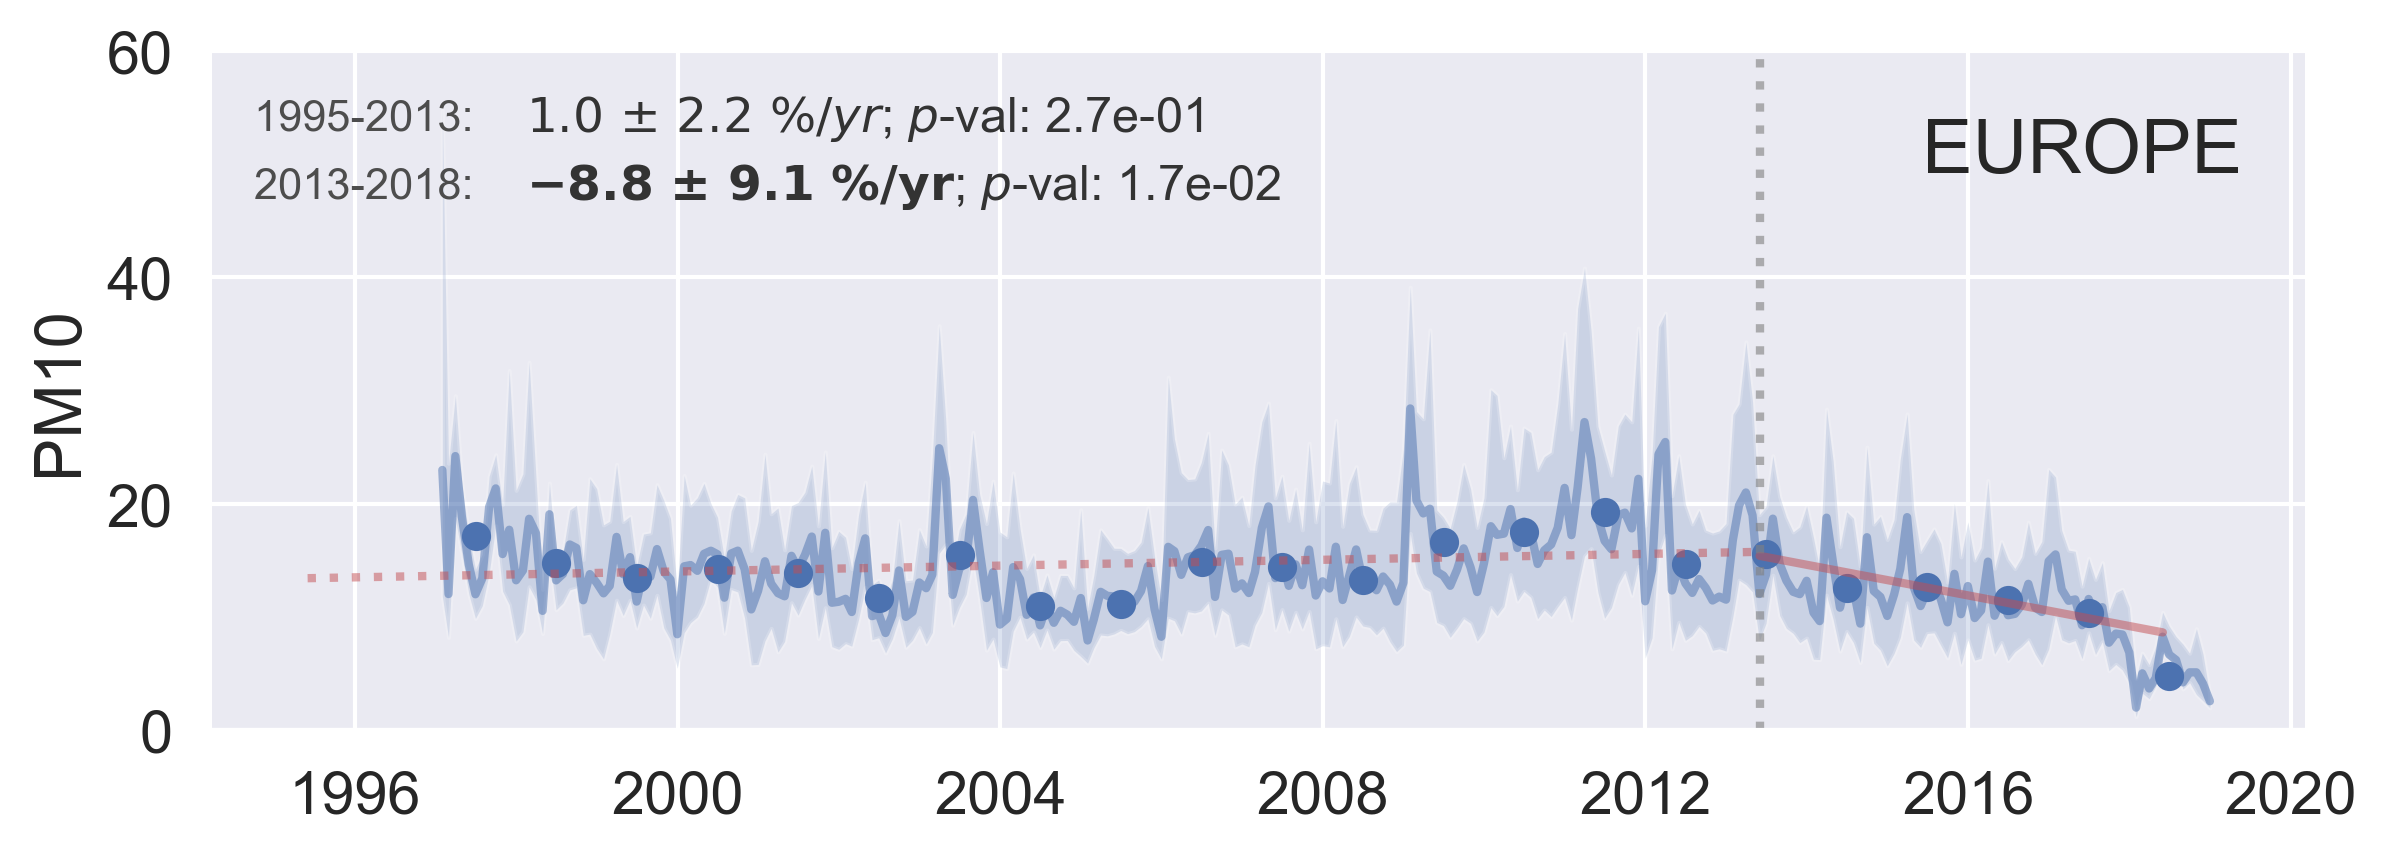

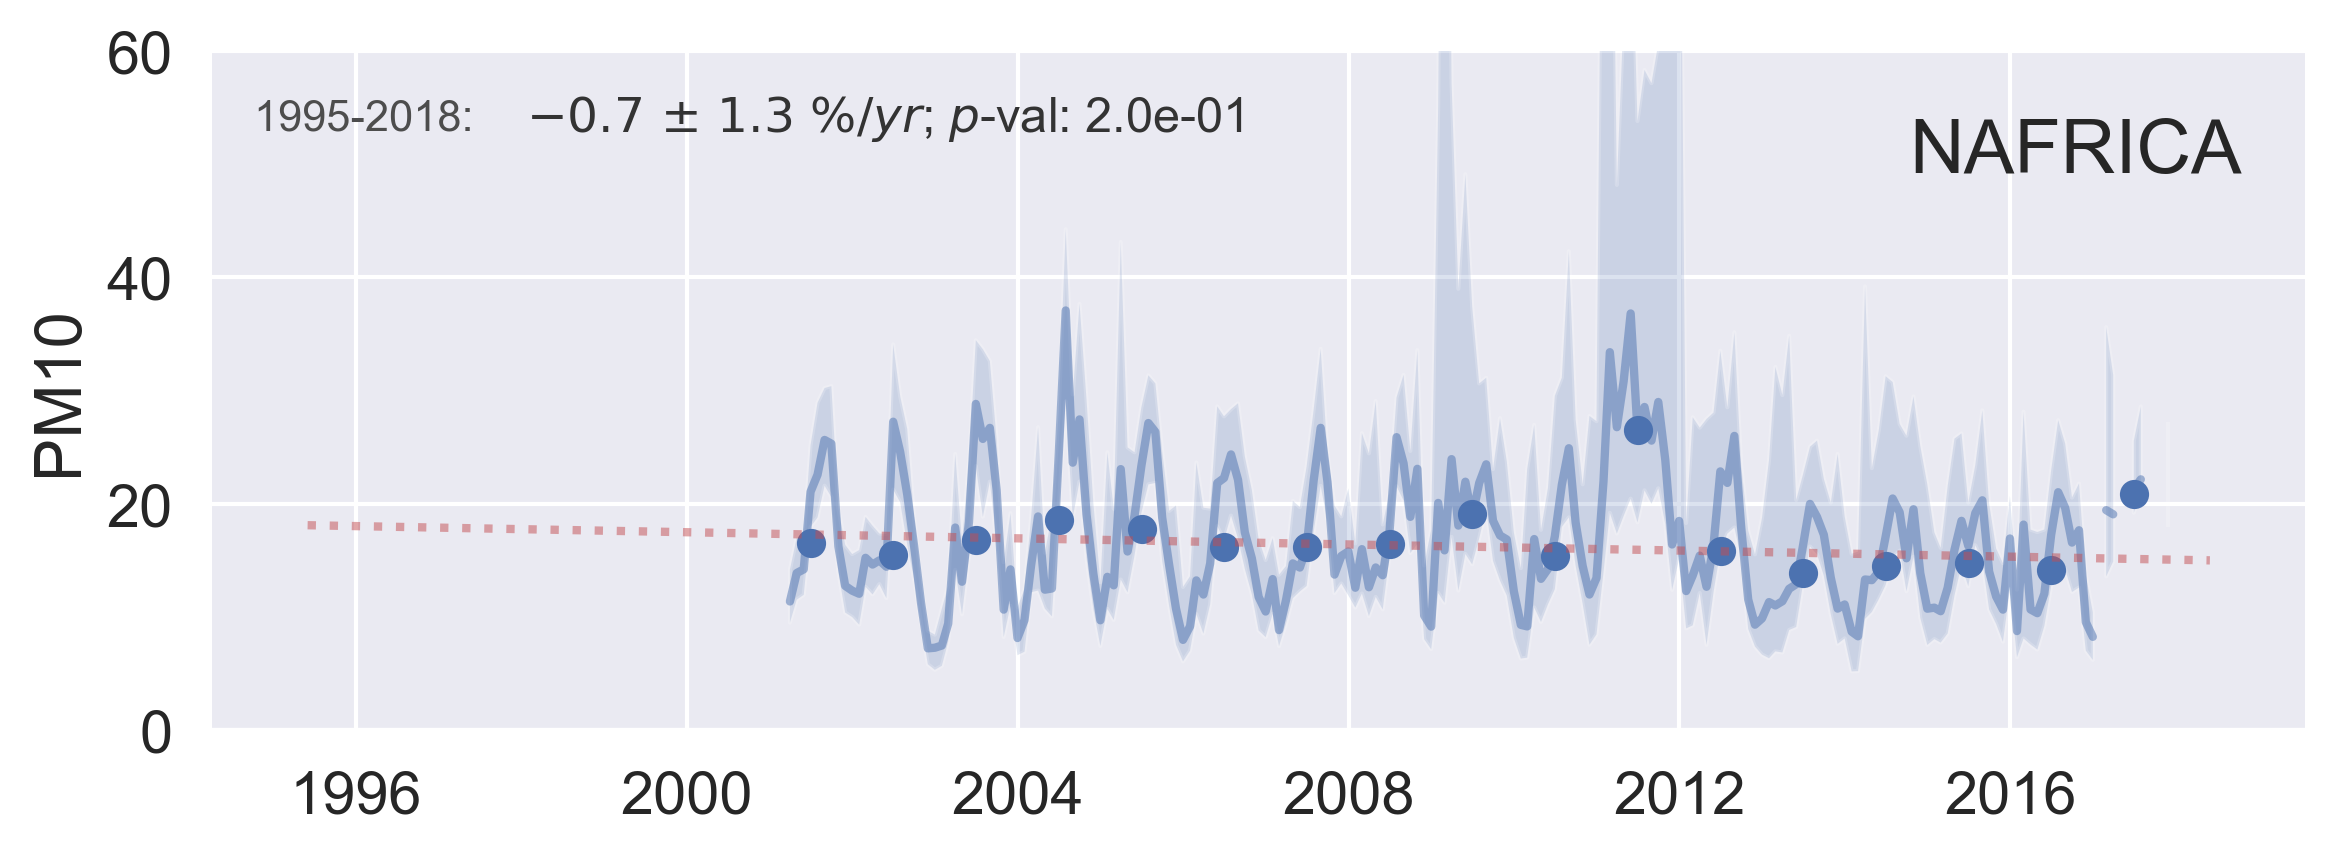

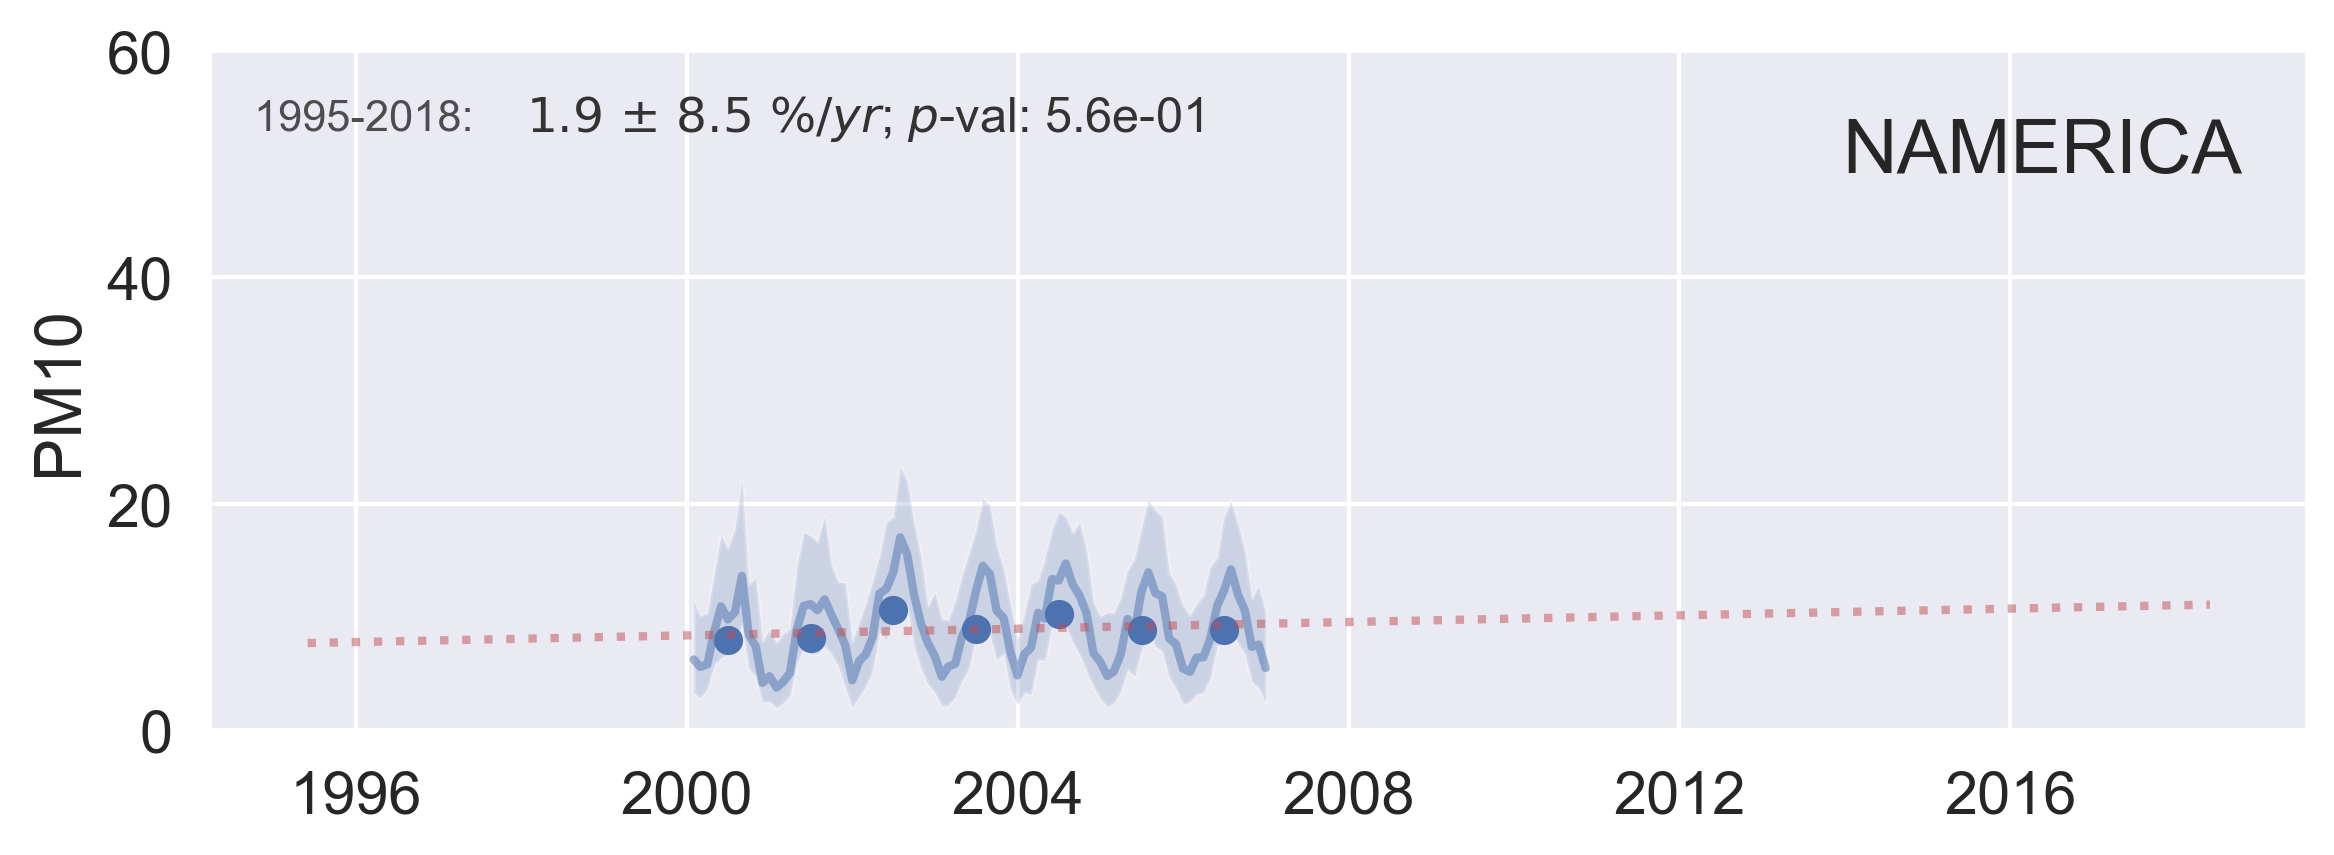

In [12]:
var =  'sconcpm10' #'ang4487aer' 'od550aer' 'od550gt1aer' 'od550lt1aer' 'sconcpm10' 'sconcpm25' 'sconcso4'
if var=='od550aer':
    source = 'AeronetSunV3Lev2.daily'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD'
    min_dim = 5
if var=='ang4487aer':
    source = 'AeronetSunV3Lev2.daily'
    ymin, ymax = 0, 2.5
    ylabel = 'AE'
    min_dim = 5
if var=='od550gt1aer':
    source = 'AeronetSDAV3Lev2.daily'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD>1µm'
    min_dim = 5
if var=='od550lt1aer':
    source = 'AeronetSDAV3Lev2.daily'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD<1µm'
if var=='sconcpm10':
    source = 'EBASMC'
    ymin, ymax = 0, 60
    ylabel = 'PM10'
    min_dim = 4 #weekly measurements!
if var=='sconcpm25':
    source = 'EBASMC'
    ymin, ymax = 0, 30
    ylabel = 'PM25'
    min_dim = 4 #weekly measurements!
if var=='sconcso4':
    source = 'EBASMC'
    ymin, ymax = 0, 6
    ylabel = 'SO4'
    min_dim = 4 #weekly measurements!
if var=='wetconcso4':
    source = 'EBASMC'
    ymin, ymax = 0, 50
    ylabel = 'SO4'
    min_dim = 4 #weekly measurements!
    
obs_source = source
reader = pya.io.ReadUngridded(source)
obs_data = reader.read(vars_to_retrieve=var)

OBS_TS, OBS_MAP, OBS_DF = process_trend(obs_data, 'obs', period, plot=True, save_plot=True, 
                                        write_json=True, ymin=ymin, ymax=ymax, ylabel=ylabel)

In [13]:
'''#plot that
fig, ax = plt.subplots(figsize=(9, 3), dpi= 300, facecolor='w', edgecolor='k')
#plot monthly averages
df = OBS_DF['EUROPE']
n = df.count(axis=1, numeric_only=False)
df['n'] = n
plt.plot(df['n'])
plt.ylabel('Number of Stations')'''

"#plot that\nfig, ax = plt.subplots(figsize=(9, 3), dpi= 300, facecolor='w', edgecolor='k')\n#plot monthly averages\ndf = OBS_DF['EUROPE']\nn = df.count(axis=1, numeric_only=False)\ndf['n'] = n\nplt.plot(df['n'])\nplt.ylabel('Number of Stations')"

#### Model colocated at obs stations but take complete ts in period

No Data Available in Selected Period


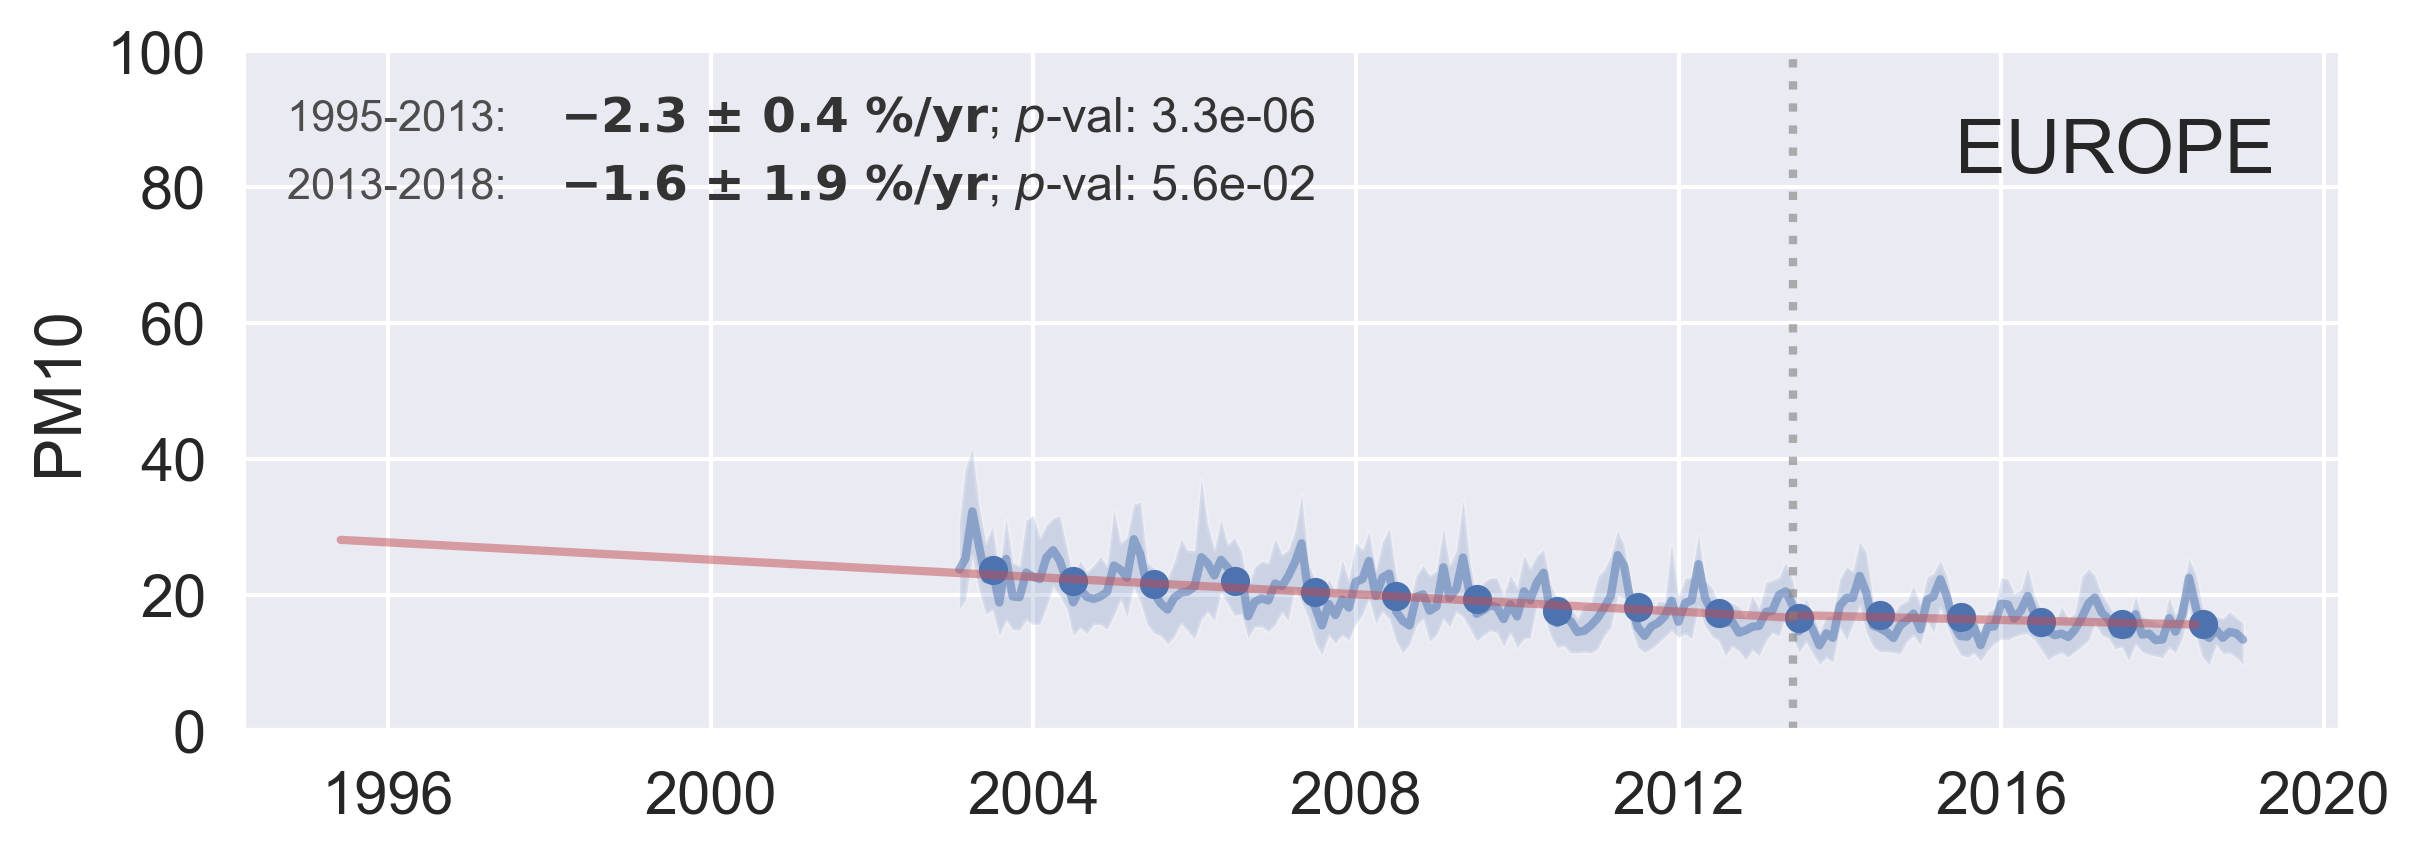

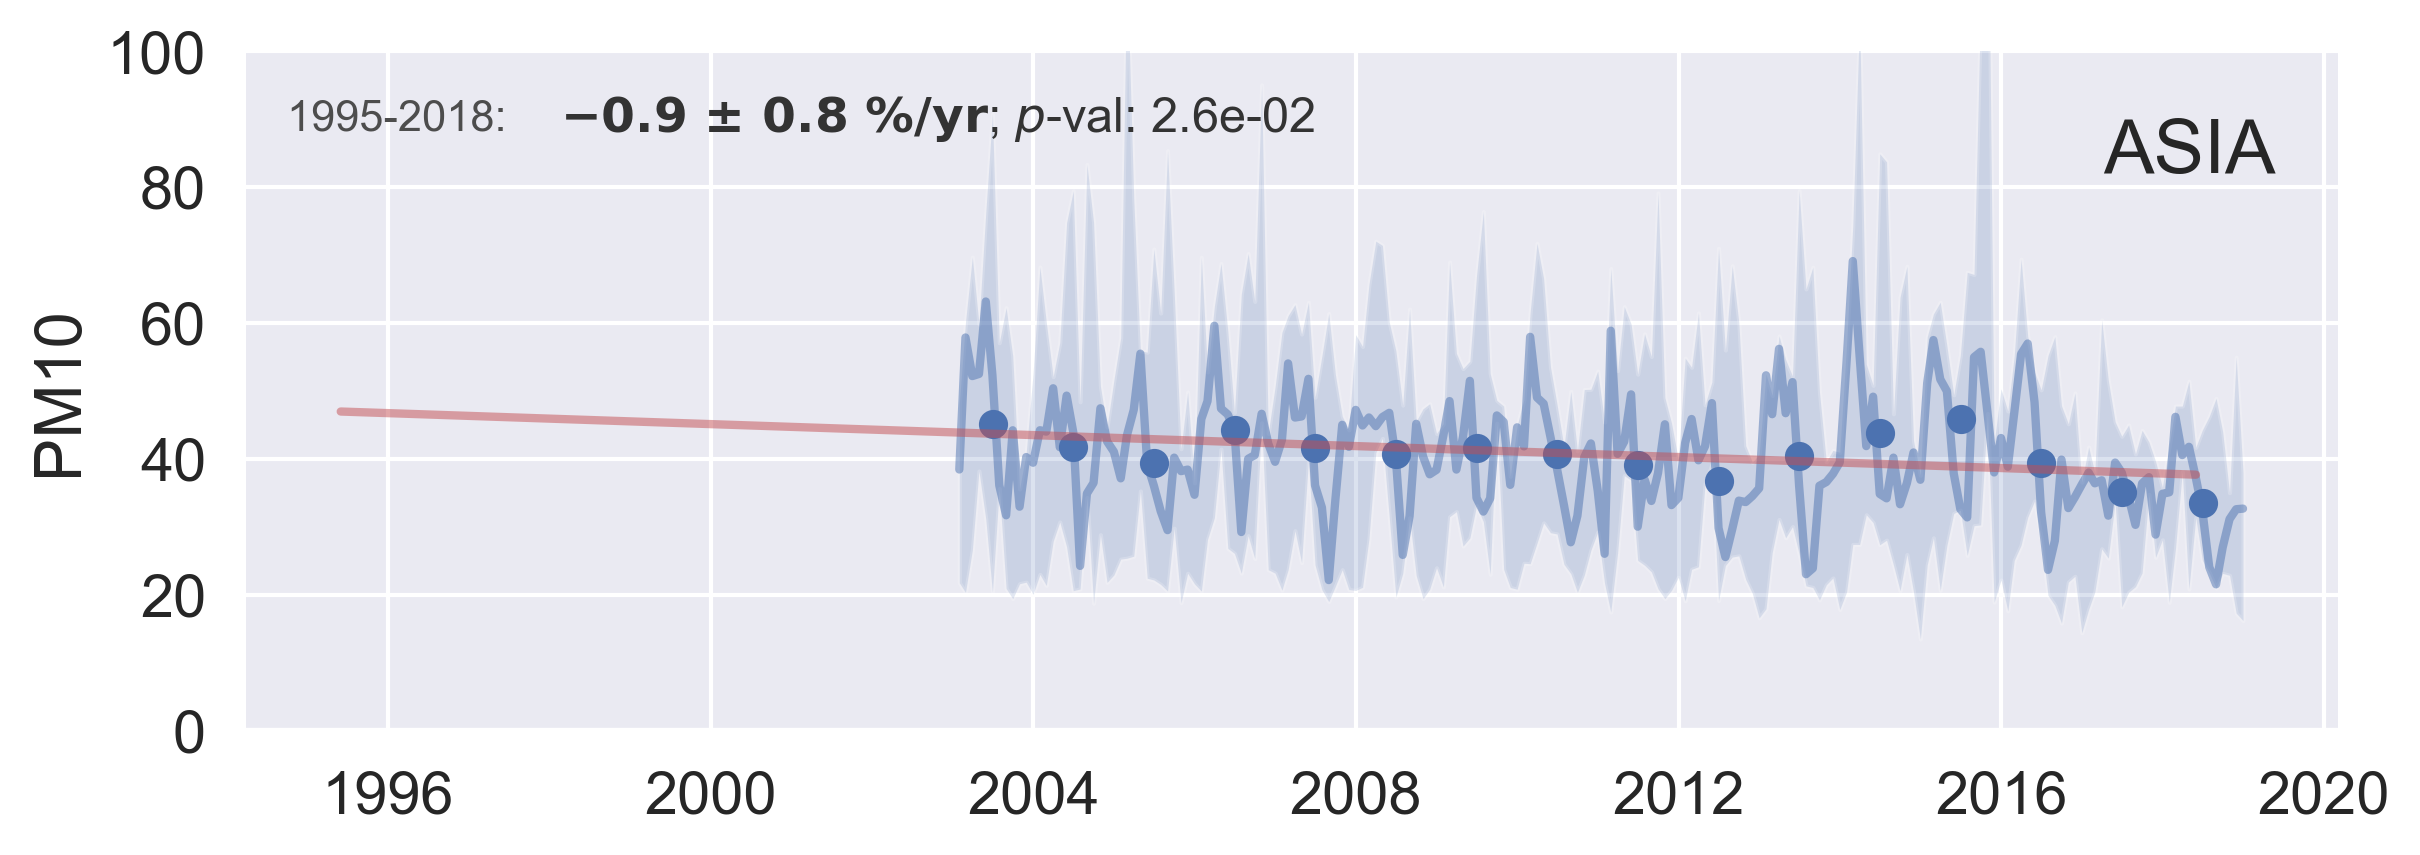

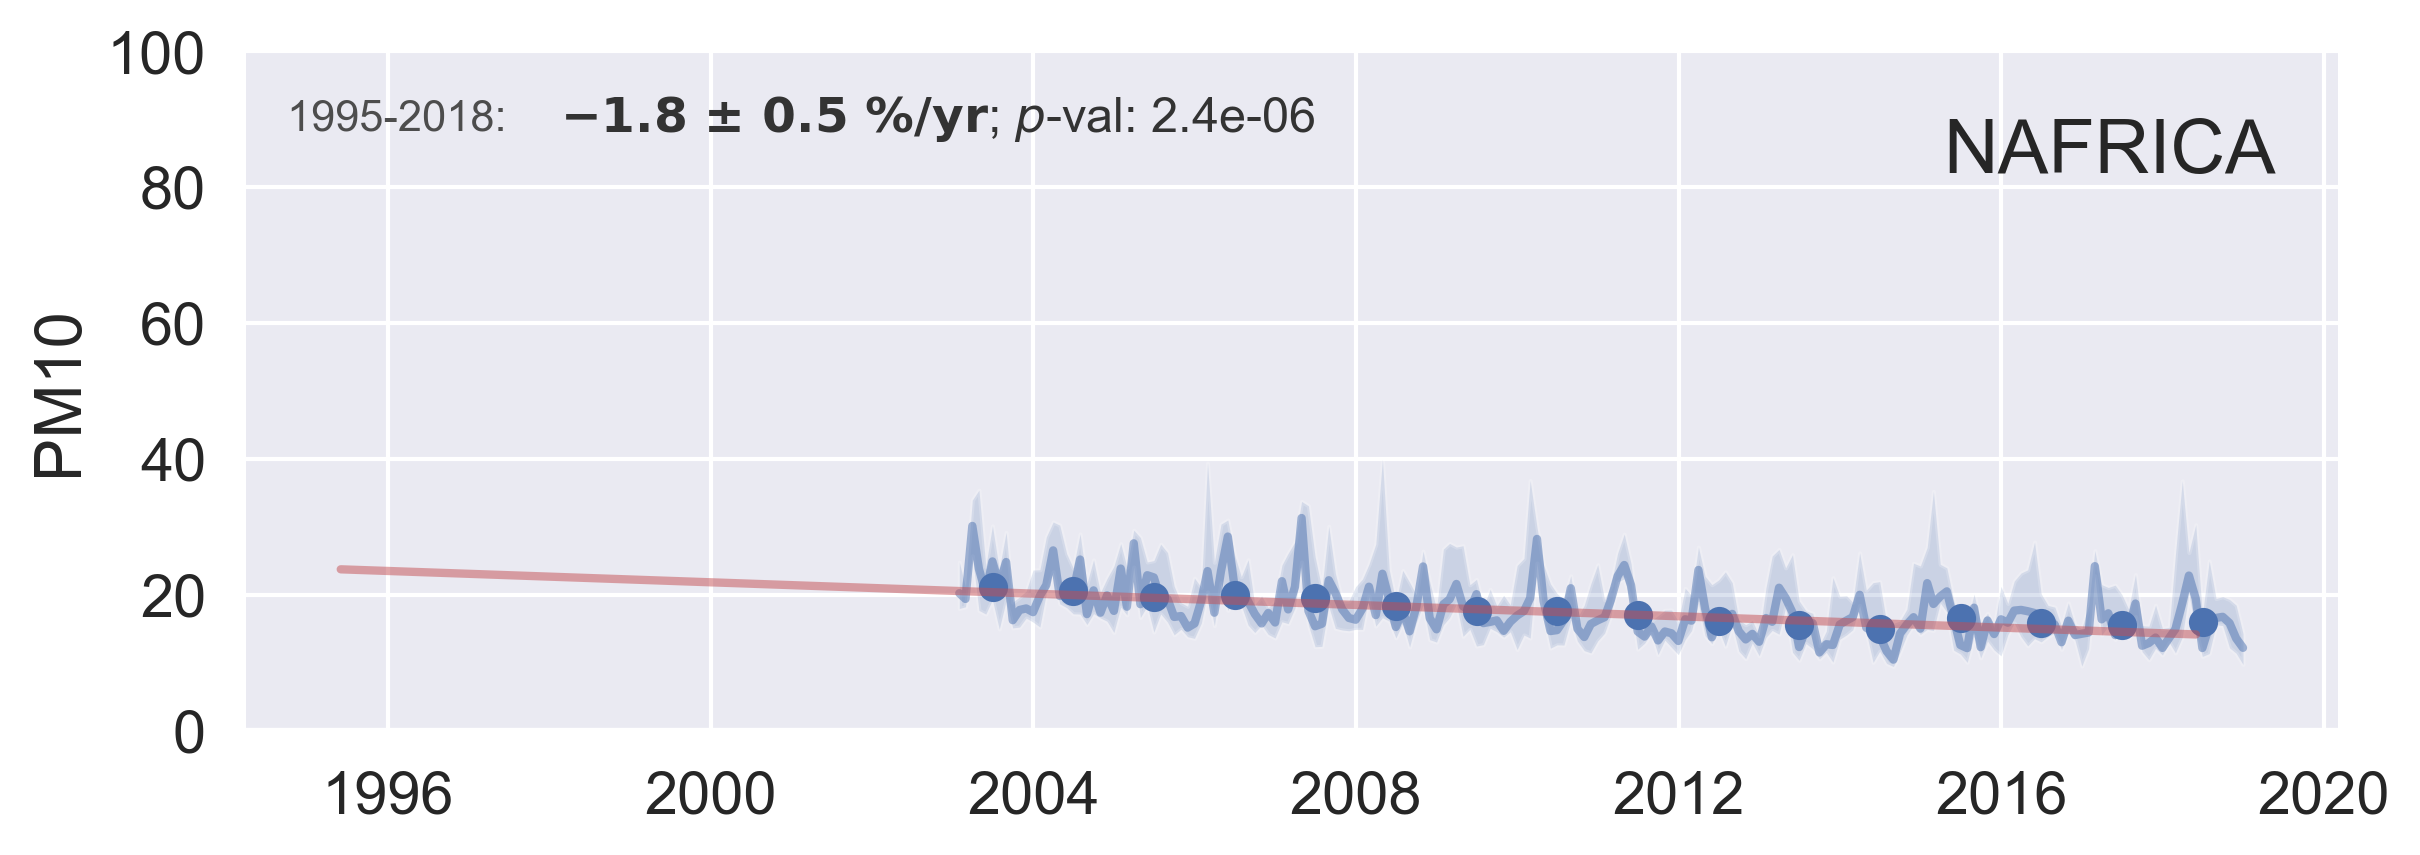

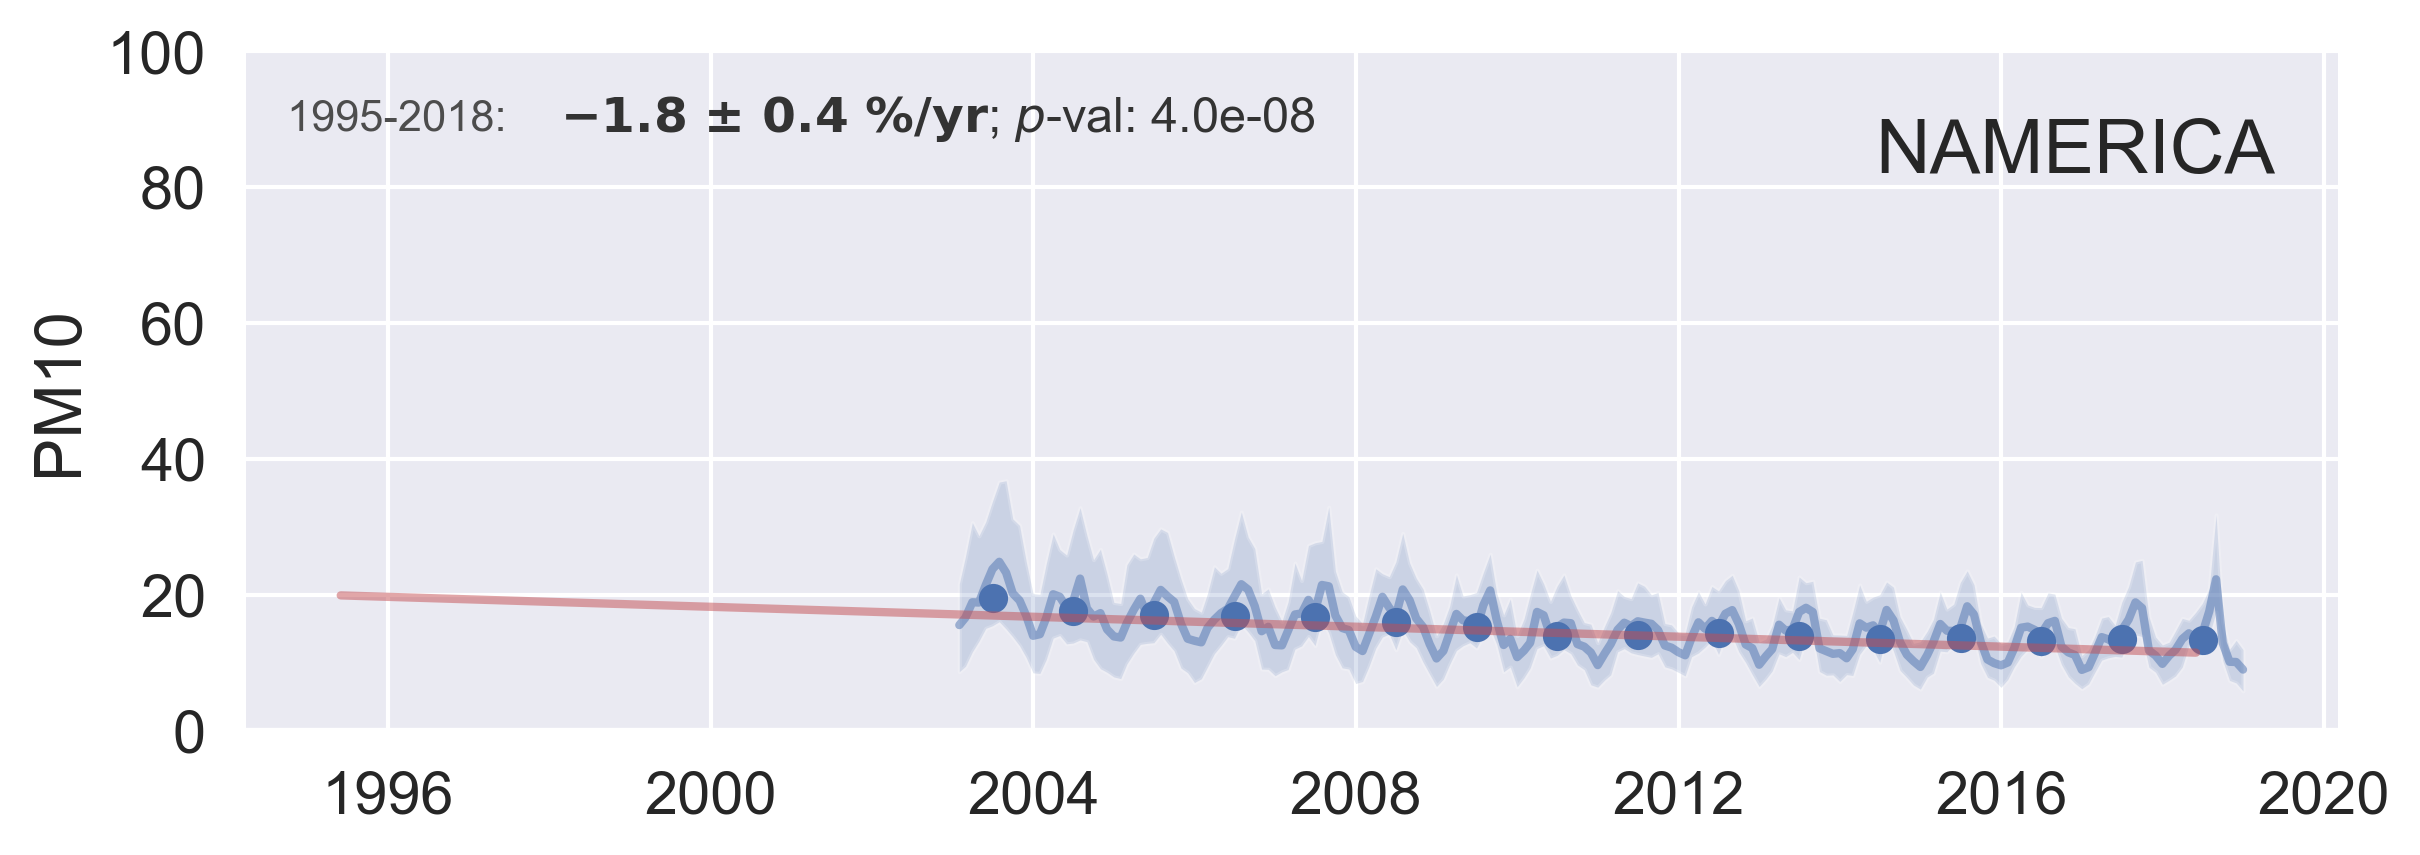

In [14]:
# for the model, set min_dim to zero since monthly data
mod_var = var
if mod_var=='od550aer':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD'
    min_dim = 0 #monthly values
if mod_var=='ang4487aer':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 2.5
    ylabel = 'AE'
    min_dim = 0 #monthly values
if mod_var=='od550gt1aer':
    source = 'GFDL-AM4-amip_HIST'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD>1µm'
    min_dim = 0 #monthly values
if mod_var=='od550lt1aer':
    source = 'GFDL-AM4-amip_HIST'
    ymin, ymax = 0, 0.8
    ylabel = 'AOD<1µm'
    min_dim = 0 #monthly values
if mod_var=='sconcpm10':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 100
    ylabel = 'PM10'
    min_dim = 0 #monthly values
if mod_var=='sconcpm25':
    source = 'ECMWF_CAMS_REAN'
    ymin, ymax = 0, 100
    ylabel = 'PM2.5'
    min_dim = 0 #monthly values
    
try:
    mod_data
    print('model alread in memory')
except NameError:
    print('model reading')
    reader = pya.io.ReadGridded(source)
    mod_data = reader.read_var(mod_var, ts_type='daily')
    mod_data = mod_data.resample_time(to_ts_type='monthly')

ALLTS_MOD_TS, ALLTS_MOD_MAP, ALLTS_MOD_DF = process_trend(mod_data, 'mod', period, obs=obs_data, 
                                                          colocate_time=False, colocate_space=True, 
                                                          plot=True, save_plot=False, write_json=False,
                                                          ymin=ymin, ymax=ymax, ylabel=ylabel)

In [15]:
'''#plot that
fig, ax = plt.subplots(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
#plot monthly averages
df = ALLTS_MOD_DF['EUROPE']
n = df.count(axis=1, numeric_only=False)
df['n'] = n
plt.plot(df['n'])
plt.ylabel('Number of Stations')'''

"#plot that\nfig, ax = plt.subplots(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')\n#plot monthly averages\ndf = ALLTS_MOD_DF['EUROPE']\nn = df.count(axis=1, numeric_only=False)\ndf['n'] = n\nplt.plot(df['n'])\nplt.ylabel('Number of Stations')"

#### Model colocated at obs stations and colocated in time with each of the stations

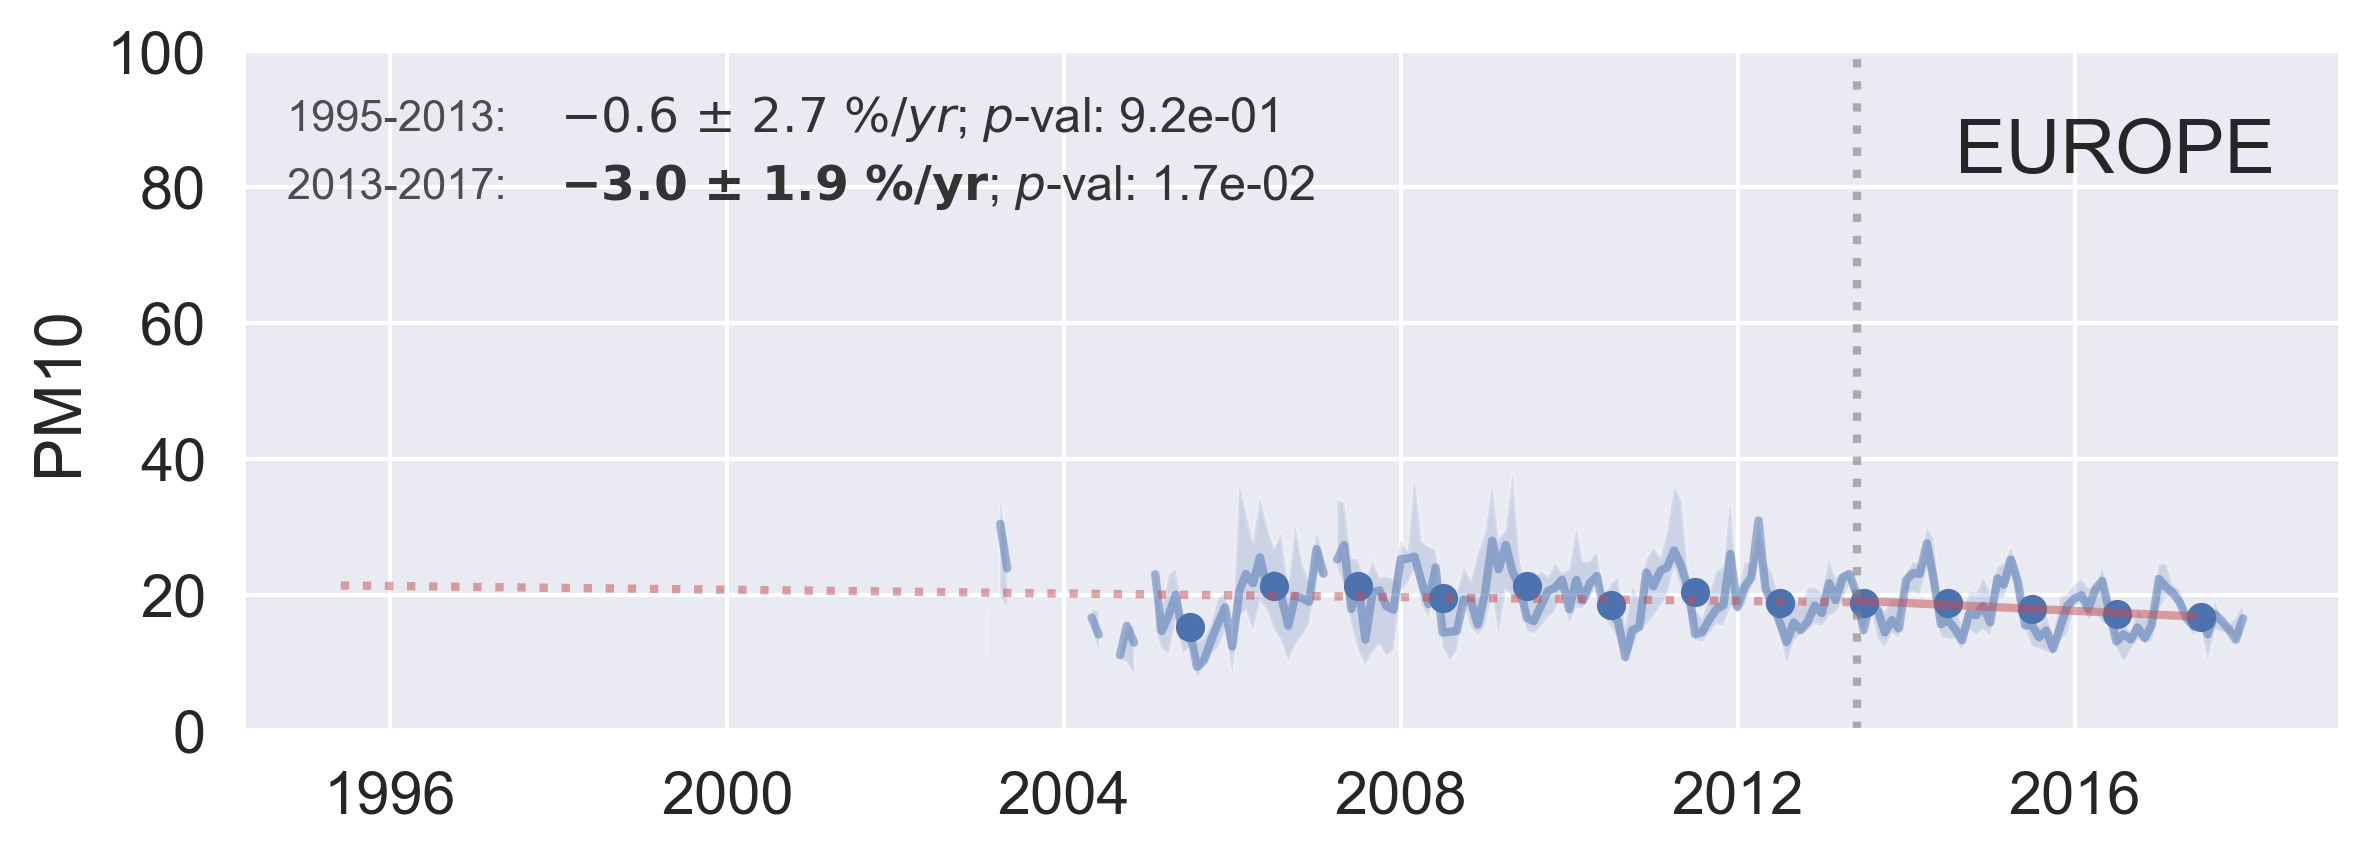

In [16]:
#MOD_TS, MOD_MAP, MOD_DF = process_trend(mod_data, 'mod', period, obs=obs_data, 
#                                        colocate_time=True, colocate_space=True, 
#                                        plot=False, write_json=False)
MOD_TS, MOD_MAP, MOD_DF = process_trend(mod_data, 'mod', period, obs=obs_data, 
                                        colocate_time=True, colocate_space=True, 
                                        plot=True, save_plot=False, write_json=False,
                                        ymin=ymin, ymax=ymax, ylabel=ylabel)

In [17]:
'''#plot that
fig, ax = plt.subplots(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
#plot monthly averages
df = MOD_DF['EUROPE']
n = df.count(axis=1, numeric_only=False)
df['n'] = n
plt.plot(df['n'])
plt.ylabel('Number of Stations')'''

"#plot that\nfig, ax = plt.subplots(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')\n#plot monthly averages\ndf = MOD_DF['EUROPE']\nn = df.count(axis=1, numeric_only=False)\ndf['n'] = n\nplt.plot(df['n'])\nplt.ylabel('Number of Stations')"

#### Model averaged with each pixel in the region. Take complete timeseries in the period.

In [18]:
REG_MOD_TS, REG_MOD_MAP, REG_MOD_DF = process_trend(mod_data, 'mod', period, obs=obs_data, 
                                                    colocate_time=False, colocate_space=False,
                                                    plot=False, write_json=False
                                                   )

/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/iris/analy

No station found in the area


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


No station found in the area


/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/home/augustinm/anaconda3/envs/pya/lib/python3.7/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


#### Print the results

In [19]:
def print_trends(MAP):
    bold_start = '\033[1m'
    bold_end = '\033[0m'
    italic_start = '(' #'\x1B[3m'
    italic_end = ')' #'\x1B[23m'
    print('region', '\t', 'period', '\t', '%/yr' , '\t\t', 'pval')
    print(' - - -', '\t', ' - - -', '\t', ' - -' , '\t\t', ' - -')
    #computation region by region
    regions = pya.region.all()
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    for region in regions:
        #get trends keys
        try:
            periods = MAP[region]['trends']['trends'].keys()
        except KeyError:
            print(region,'\t','Key Error')
            continue
        for p, per in enumerate(periods):
            r = MAP[region]['trends']['trends'][per]
            if p==0:
                str_region = region[0:5]
                str_nmax = MAP[region]['nmax']
            else:
                str_region = ' '
                str_nmax = ' '
            if r['pval']!=None:
                if r['pval']<=0.1:
                    fstyle_start = bold_start
                    fstyle_end = bold_end
                if r['pval']>=0.1 and r['pval']<0.2:
                    fstyle_start = ''
                    fstyle_end = ''
                if r['pval']>0.2:
                    fstyle_start = italic_start
                    fstyle_end = italic_end
                print(str_region, '\t', per , '\t', fstyle_start, round(r['rel_slp'],1),'±',round(r['err_rel_slp'],1), fstyle_end, '\t', round(r['pval'],2))
                
            else:
                print(str_region, '\t', per, '\t', 'None', '±','None', '\t', 'None')
    print()

In [20]:
print(' * * OBS * *')
print_trends(OBS_MAP)
print(' * * MOD * *')
print_trends(MOD_MAP)
print(' * * ALLTS_MOD * *')
print_trends(ALLTS_MOD_MAP)
print(' * * REG_MOD * *')
print_trends(REG_MOD_MAP)

 * * OBS * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
EUROP 	 1995-2013 	 ( 1.0 ± 2.2 ) 	 0.27
  	 2013-2018 	  -8.8 ± 9.1  	 0.02
AUSTRALIA 	 Key Error
NAFRI 	 1995-2018 	 ( -0.7 ± 1.3 ) 	 0.2
SAFRICA 	 Key Error
NAMER 	 1995-2018 	 ( 1.9 ± 8.5 ) 	 0.56

 * * MOD * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
EUROP 	 1995-2013 	 ( -0.6 ± 2.7 ) 	 0.92
  	 2013-2017 	  -3.0 ± 1.9  	 0.02
ASIA 	 Key Error
AUSTRALIA 	 Key Error
SAFRICA 	 Key Error
SAMERICA 	 Key Error

 * * ALLTS_MOD * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
EUROP 	 1995-2013 	  -2.3 ± 0.4  	 0.0
  	 2013-2018 	  -1.6 ± 1.9  	 0.06
ASIA 	 1995-2018 	  -0.9 ± 0.8  	 0.03
AUSTRALIA 	 Key Error
NAFRI 	 1995-2018 	  -1.8 ± 0.5  	 0.0
SAFRICA 	 Key Error
NAMER 	 1995-2018 	  -1.8 ± 0.4  	 0.0

 * * REG_MOD * *
region 	 period 	 %/yr 		 pval
 - - - 	  - - - 	  - - 		  - -
EUROP 	 1995-2013 	 ( -0.0 ± 0.6 ) 	 0.88
  	 2013-2018 	 ( -0.7 ± 2.6 ) 	 0.47
ASIA 	 1995-20

In [21]:
def consistency(diff):
    norm = 1
    mu = 0
    stdv = 0.85
    gauss = 100*norm*np.exp(-0.5*(((diff-mu)/stdv)**2))
    
    consistency = gauss
    return consistency

In [22]:
def print_consistency(MOD, ALLTS_MOD, REG_MOD):
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    print('region', ' ', 'period', ' ', 'slp (%/yr)', ' ', 'allTS-slp (%/yr)', ' ', 'reg-slp (%/yr)', ' ', 'time_consist', ' ', 'space_consist',' ', 'consist')
    print(' - - -', ' ', ' - - -', ' ', ' - - - - - - -', ' ', ' - - - - - - -', ' ', ' - - - - - - -', ' ', ' - - - - - -', ' ', ' - - - - - - ')
    regions = ['EUROPE', 'ASIA', 'AUSTRALIA', 'NAFRICA', 'SAFRICA', 'NAMERICA', 'SAMERICA']
    for region in regions:
        #get trends keys
        try:
            periods = MOD[region]['trends']['trends'].keys()
        except KeyError:
            print(region,'Key Error')
            continue
        for p, per in enumerate(periods):
            try:
                r = MOD[region]['trends']['trends'][per]
                allts_r = ALLTS_MOD[region]['trends']['trends'][per]
                reg_r = REG_MOD[region]['trends']['trends'][per]
            except KeyError:
                print('\t',per,'\t','Key Error')
                continue
            
            if p==0:
                str_region = region[0:5]
            else:
                str_region = ' '
            
            if r['rel_slp']!=None and allts_r['rel_slp']:
                slp = r['rel_slp']
                allts_slp = allts_r['rel_slp']
                reg_slp = reg_r['rel_slp']
                
                time_diff = (allts_slp-slp)#/slp
                space_diff = (allts_slp-reg_slp)#/reg_slp
                
                time_consist = consistency(time_diff)
                space_consist = consistency(space_diff)
                
                all_consist = np.mean([time_consist, space_consist])
                
                str_slp = round(slp,1) #all colocated: time and space
                str_reg_slp = round(reg_slp,1)#no colocation at all: regoins, complete time series
                str_allts_slp = round(allts_slp,1) #spactial colocation, complete time series
                
            else:
                time_diff = np.nan
                space_diff = np.nan
                time_consist = np.nan
                space_consist = np.nan
                all_consist = np.nan
                accuracy = np.nan
                str_slp = None
                str_allts_slp = None
                str_reg_slp = None
                
            print(str_region, '\t', per , '\t', str_slp ,'\t', str_allts_slp , '\t', str_reg_slp , '\t',
                  #round(time_diff,1), '\t',
                  #round(space_diff,1), '\t',
                  '\033[1m', '{:.0f}'.format(round(time_consist,0)), '\t', 
                  '\033[1m', '{:.0f}'.format(round(space_consist,0)), '\033[0m', '\t',
                  '\033[1m', '{:.0f}'.format(round(all_consist,0)), '\033[0m' '\t',
                 )
            
    print()

In [23]:
#computation region by region
print(' * * CONSISTENCY * *')
print_consistency(MOD_MAP, ALLTS_MOD_MAP, REG_MOD_MAP)

 * * CONSISTENCY * *
region   period   slp (%/yr)   allTS-slp (%/yr)   reg-slp (%/yr)   time_consist   space_consist   consist
 - - -    - - -    - - - - - - -    - - - - - - -    - - - - - - -    - - - - - -    - - - - - - 
EUROP 	 1995-2013 	 -0.6 	 -2.3 	 -0.0 	  16 	  3  	  10 	
	 2013-2017 	 Key Error
ASIA Key Error
AUSTRALIA Key Error
SAFRICA Key Error
SAMERICA Key Error



Text(0, 0.5, 'Consistency (%)')

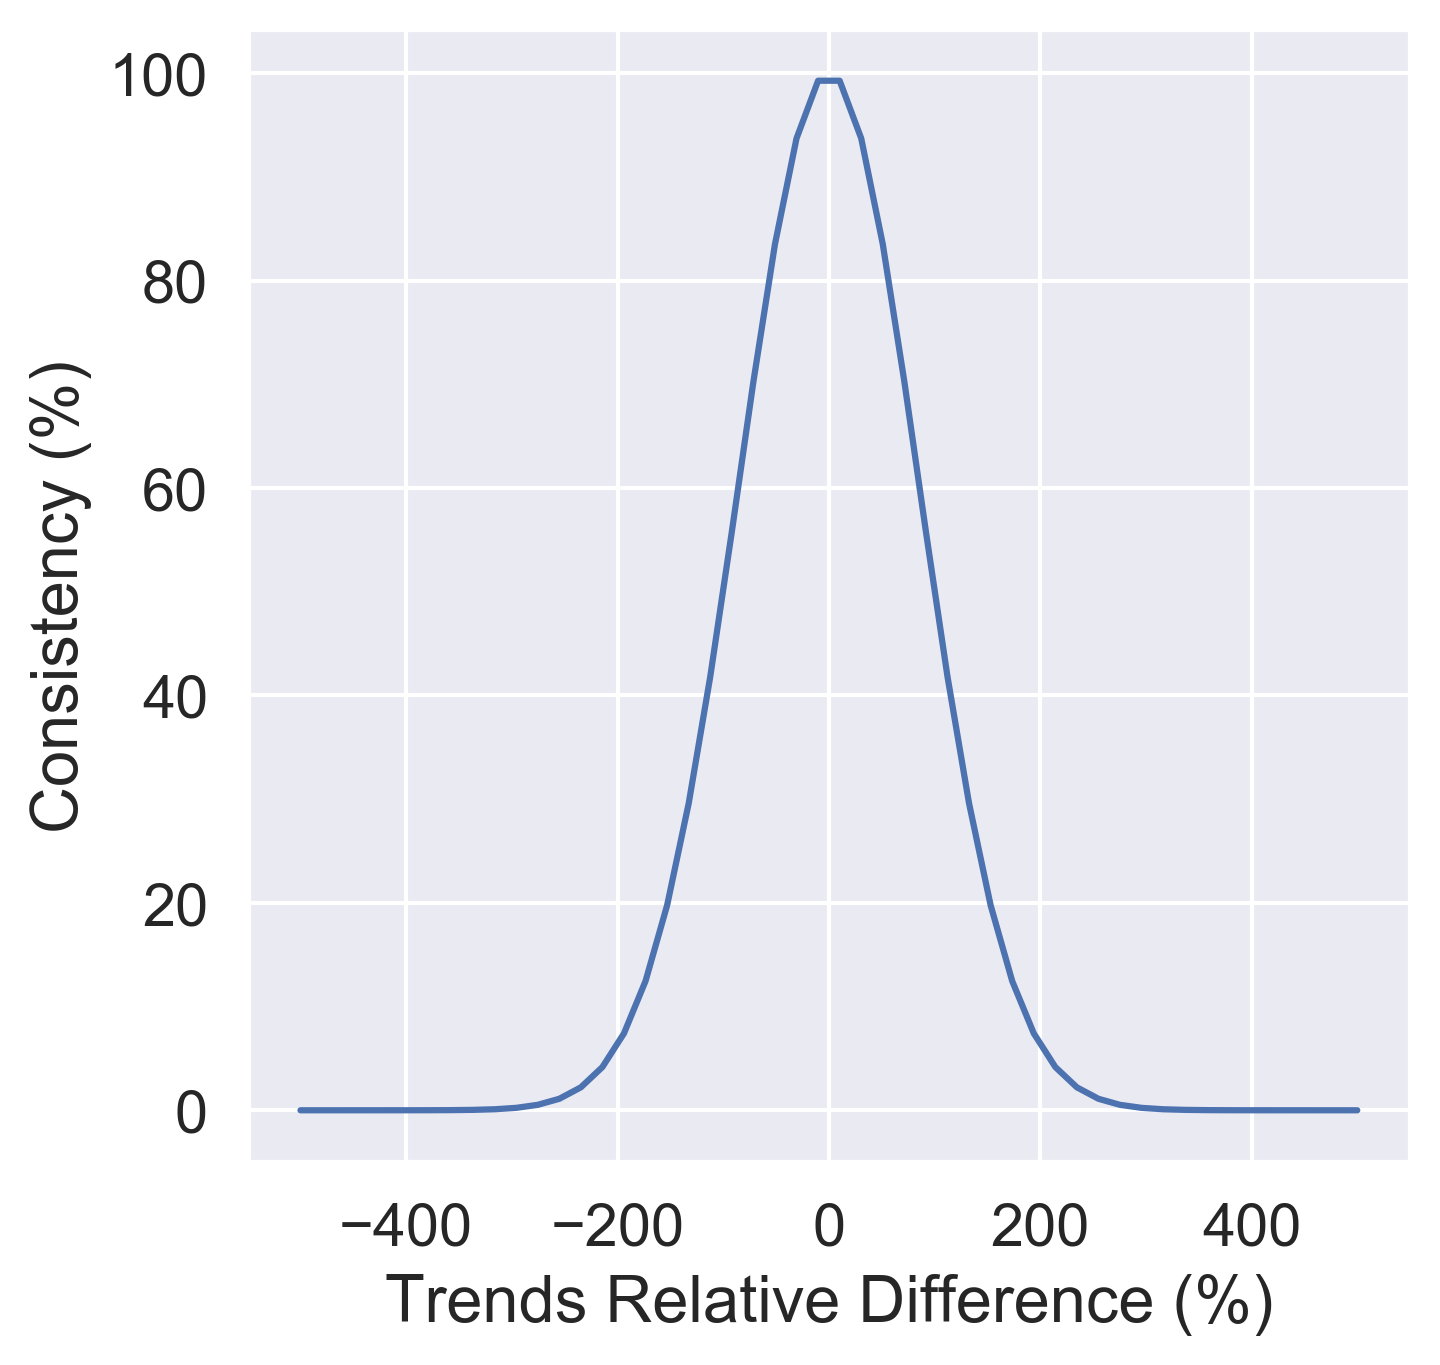

In [24]:
#plot consistency as function of difference
fig, ax = plt.subplots(figsize=(5, 5), dpi= 300, facecolor='w', edgecolor='k')
x = np.linspace(-5,5,50)
y = [consistency(val) for val in x]
plt.plot(x*100,y)
plt.xlabel('Trends Relative Difference (%)')
plt.ylabel('Consistency (%)')